**Data Collection**

In this part we will use beautifulsoup package to scrape two book from Gutenberg 

In [1]:
!pip install requests
!pip install beautifulsoup4

In [2]:
# import
import requests
from bs4 import BeautifulSoup

In [3]:
def get_response(url):
  response = requests.get(url)
  return response

In [4]:
# Set the URL you want to scrape from
url1='https://www.gutenberg.org/files/28054/28054-h/28054-h.htm'
url2='https://www.gutenberg.org/files/1998/1998-h/1998-h.htm#link2H_4_0029'
# Connect to the URL and download document
response1 = get_response(url1)
response2 = get_response(url2)

In [5]:
def get_whole_content(response):
  soup =  BeautifulSoup(response.text, "html.parser")
  return soup

In [6]:
# Parse HTML and save to BeautifulSoup object
soup1 = get_whole_content(response1)
soup2 = get_whole_content(response2)

In [7]:
#use inner function in beautiful soup to part book
def part_book1(soup):
  import re
  import pandas as pd
  df = pd.DataFrame(columns=['Author','Chapter','Content'])
  author = ''.join(soup1.find('h2').contents)
  whole_content = soup.find_all('div')
  n=1

  for i in whole_content:
    if i.a is not None:
      if i.a.get('name') and (len(i.h2.contents) >2):
        chapter = i.h2.contents[3]
        text = i.find_all('p')
        doc=''
        for i in text:
          doc += i.get_text()

        df_t = pd.DataFrame(columns=['Author','Chapter','Content'])
        df_t.loc[n,'Author'] = author
        df_t.loc[n,'Chapter'] = chapter
        df_t.loc[n,'Content'] = doc
        n = n+1
        df = df.append(df_t)
  return df

In [8]:
df1 = part_book1(soup1)

In [9]:
#use regular expression to part book
def part_book2(soup):
  import re
  import pandas as pd
  text = soup.find_all(['p','h2'])
  text = str(text)
  soup2 = BeautifulSoup(text, "html.parser")
  content = soup2.get_text()
  df = pd.DataFrame(columns=['Author','Chapter','Content'])
  Main_Part = re.split('NOTES ON',content)
  Part = re.split('[A-Z]* PART',Main_Part[1])
  for string in soup.find_all('h2')[1].stripped_strings:
    author = repr(string)
  df_t = pd.DataFrame(columns=['Author','Chapter','Content'])
  n = 1
  doc = ""
  for i in range(len(Part)-4,len(Part)):
    Chapter = re.split('[A-Z]+\. (.*)\.',Part[i])
    for j in range(len(Chapter)):
      doc += Chapter[j]   
      if len(Chapter[j]) <40:
        df_t.loc[n,'Content'] = doc 
        n = n+1      
        df = df.append(df_t)
        df_t = pd.DataFrame(columns=['Author','Chapter','Content'])
        df_t.loc[n,'Author'] = author
        df_t.loc[n,'Chapter'] = Chapter[j]
        doc = ""
  df_t.loc[n,'Content'] = doc 
  df = df.append(df_t)
  df.loc[1,'Author'] = author
  df.loc[1,'Chapter'] = 'ZARATHUSTRA’S DISCOURSES'
  return df

In [10]:
df2 = part_book2(soup2)
df = df1.append(df2)
df

Author  ...                                            Content
1         Fyodor Dostoyevsky  ...  \r\nAlexey Fyodorovitch Karamazov was the thir...
2         Fyodor Dostoyevsky  ...  \r\nYou can easily imagine what a father such ...
3         Fyodor Dostoyevsky  ...  \r\nVery shortly after getting his fourâyear...
4         Fyodor Dostoyevsky  ...  \r\nHe was only twenty, his brother Ivan was i...
5         Fyodor Dostoyevsky  ...  \r\nSome of my readers may imagine that my you...
..                       ...  ...                                                ...
77  'By Friedrich Nietzsche'  ...  \r\n    , \r\n      “Go not away!” said then t...
78  'By Friedrich Nietzsche'  ...  \r\n    , \r\n      After the song of the wand...
79  'By Friedrich Nietzsche'  ...  \r\n    , \r\n      At this place in the litan...
80  'By Friedrich Nietzsche'  ...  \r\n    , \r\n      Meanwhile one after anothe...
81  'By Friedrich Nietzsche'  ...  \r\n    , \r\n      In the morning, however, a...

[177 rows x 3 columns]

**Data Processing**

We should do some text cleaning before we use classification method

In [11]:
import nltk
nltk.download('punkt')
import random
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.tokenize import RegexpTokenizer
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
from gensim import utils
import gensim.parsing.preprocessing as gsp
#get rid of tags,punctuation and something else
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [13]:
#creat segments
def Split_content(df):
  df_h =  pd.DataFrame(columns=['Author','Chapter','Content'])
  len_text = 100
  index_n = 1
  for i in range(len(df)):
    text = df.iloc[i]['Content']
    text_words = clean_text(text).split(' ')
    doc = ''
    if len(text_words)%len_text != 0:
      slice_number = len(text_words)//len_text+1
      for j in range(slice_number):
        if j < slice_number-1: 
          df_w = pd.DataFrame(columns=['Author','Chapter','Content'])
          doc = ' '.join(text_words[j*len_text:(j+1)*len_text])
          df_w.loc[index_n,'Author']=  gsp.strip_punctuation(df.iloc[i]['Author'])
          df_w.loc[index_n,'Chapter']= gsp.strip_multiple_whitespaces(df.iloc[i]['Chapter'])
          df_w.loc[index_n,'Content']= doc
          df_h = df_h.append(df_w)
          index_n += 1
          doc = ''
        else:
          df_w = pd.DataFrame(columns=['Author','Chapter','Content'])
          doc = ' '.join(text_words[j*len_text:(j+1)*len_text])
          df_w.loc[index_n,'Author']= gsp.strip_punctuation(df.iloc[i]['Author'])
          df_w.loc[index_n,'Chapter']= gsp.strip_multiple_whitespaces(df.iloc[i]['Chapter'])
          df_w.loc[index_n,'Content']= doc
          index_n += 1
          doc = ''
          df_h = df_h.append(df_w)
  return df_h

In [14]:
df_h = Split_content(df)
df_h

Author  ...                                            Content
1           Fyodor Dostoyevsky  ...  alexei fyodorovitch karamazov son fyodor pavlo...
2           Fyodor Dostoyevsky  ...  rich distinguish nobl famili landown district ...
3           Fyodor Dostoyevsky  ...  suppos brief moment fyodor pavlovitch spite pa...
4           Fyodor Dostoyevsky  ...  life everlast scene said young wife show incom...
5           Fyodor Dostoyevsky  ...  introduc regular harem hous abandon orgi drunk...
...                        ...  ...                                                ...
1885   By Friedrich Nietzsche   ...  morn night zarathustra jump couch have gird lo...
1886   By Friedrich Nietzsche   ...  honoureth sun eagl talon doth grasp new light ...
1887   By Friedrich Nietzsche   ...  knee —unwil leav love like dog findeth old mas...
1888   By Friedrich Nietzsche   ...  zarathustra roar wildli sprang cave higher men...
1889   By Friedrich Nietzsche   ...  suffer fellow suffer higher men cri counten ch...

[1889 rows x 3 columns]

doc2vec

In [15]:
import gensim
#tagged text
TaggededDocument = gensim.models.doc2vec.TaggedDocument
tagged_x = [TaggededDocument(row.split(' '),tags = [df_h.iloc[index]['Author'],df_h.iloc[index]['Chapter']]) for index, row in enumerate(df_h['Content'])]
print(tagged_x)

[TaggedDocument(words=['alexei', 'fyodorovitch', 'karamazov', 'son', 'fyodor', 'pavlovitch', 'karamazov', 'land', 'owner', 'known', 'district', 'dai', 'rememb', 'ow', 'gloomi', 'tragic', 'death', 'happen', 'thirteen', 'year', 'ago', 'shall', 'proper', 'place', 'present', '“landowner”—for', 'hardli', 'spent', 'dai', 'life', 'estate—wa', 'strang', 'type', 'pretti', 'frequent', 'met', 'type', 'abject', 'viciou', 'time', 'senseless', 'senseless', 'person', 'capabl', 'look', 'worldli', 'affair', 'appar', 'fyodor', 'pavlovitch', 'instanc', 'began', 'estat', 'smallest', 'ran', 'dine', 'men’', 'tabl', 'fasten', 'toadi', 'death', 'appear', 'thousand', 'roubl', 'hard', 'cash', 'time', 'life', 'senseless', 'fantast', 'fellow', 'district', 'repeat', 'stupidity—th', 'major', 'fantast', 'fellow', 'shrewd', 'intellig', 'enough—but', 'senseless', 'peculiar', 'nation', 'form', 'marri', 'twice', 'son', 'eldest', 'dmitri', 'wife', 'ivan', 'alexei', 'second', 'fyodor', 'pavlovitch’', 'wife', 'adelaã¯da', 

In [16]:
from sklearn import utils as skl_utils
from tqdm import tqdm
#build doc2vec model
transform_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
transform_model.build_vocab(tagged_x)
transform_model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=transform_model.epochs)

100%|██████████| 1889/1889 [00:00<00:00, 315169.27it/s]


In [17]:
#a test of model
doc = 'love is the highest thing in the world'
text_words = nltk.word_tokenize(doc)
text_words = [w for w in text_words if (w.lower() not in stop_words) and (w.isdigit() or w.isalpha())]
vector = transform_model.infer_vector(text_words)
print(vector)
sims = transform_model.docvecs.most_similar([vector],topn=10)
print(sims)

[-0.38824818 -0.12672172  0.06763523 -0.10886025  0.21384789 -0.27123183
  0.07798726  0.11927627  0.04376328  0.07013655  0.21715838 -0.10025468
 -0.21310377  0.02976431  0.14566295  0.29974136  0.1434379   0.07625125
 -0.15684752 -0.34291723  0.0144657   0.06582602  0.02696737 -0.1878433
 -0.04912265  0.0479349   0.2902262   0.14642313 -0.02399497  0.01059214
  0.32564875 -0.03391669  0.11063027 -0.43590325 -0.17207263  0.06569102
 -0.48120216 -0.1871656   0.01413401  0.02409418  0.25683495  0.00482056
  0.09916254  0.15754308  0.1655978  -0.1637756  -0.02969496  0.13101393
 -0.3511236   0.13368583]
[('Fyodor Dostoyevsky', 0.5665435791015625), ('THE SEVEN SEALS', 0.49864912033081055), (' By Friedrich Nietzsche ', 0.4836173355579376), ('THE NIGHT-SONG', 0.3192007839679718), ('THE SPIRIT OF GRAVITY', 0.29546937346458435), ('NEIGHBOUR-LOVE', 0.2869831919670105), ('THE CHILD WITH THE MIRROR', 0.28361088037490845), (' “I Am Coming, Too!”', 0.26124265789985657), ('THE THREE EVIL THINGS', 0

**XGBoost model**

We will use XGBoost method to do our classification

In [18]:
!pip install XGBoost

In [19]:
#Train test spilt
from sklearn.model_selection import train_test_split,cross_val_score
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
#We can use author name as label, this is binary classification; or we can use chapter name as label, this will be multi-class classification
def split(df,single = True, multi = False):
  X = df['Content']
  if single == True:
    y = df[['Author']].values.ravel()
  if multi == True: 
    y = df[['Chapter']].values.ravel()
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify = y)
  return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test= split(df_h,0,1)

In [20]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
#build XGBoost model
X_train_BOW = np.asmatrix(np.array([transform_model.infer_vector(row.split()) for index, row in enumerate(X_train)]))
X_test_BOW = np.asmatrix(np.array([transform_model.infer_vector(row.split()) for index, row in enumerate(X_test)]))
#if we use binary classificaiton we should use the first objective
#objective ='binary:logistic'
#if we use multi-class classificaiton we should use the second objective
objective = 'multi:softmax'
model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective=objective, eta=0.3, silent=1, subsample=0.8)
model.fit(X_train_BOW, y_train) 
prediction = model.predict(X_test_BOW)
cm = confusion_matrix(y_test, prediction)
scores = cross_val_score(model, X_train_BOW, y_train, cv=5)
print(cm)  
print('Test Accuracy', accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))
print('Mean Accuracy of Cross Validation',scores.mean())  

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 4]]
Test Accuracy 0.6296296296296297
                                                              precision    recall  f1-score   support

                                      A Corrupter Of Thought       1.00      1.00      1.00         3
                                           A Critical Moment       0.40      1.00      0.57         2
                                         A Hymn And A Secret       0.75      0.60      0.67         5
                                 A Laceration In The Cottage       0.50      0.67      0.57         3
                          A Laceration In The DrawingâRoom       0.75      0.75      0.75         4
                                      A Lady Of Little Faith       0.00      0.00      0.00         2
                                              A Little Demon       0.00      0.00      0.00         2
                              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# we create an instance of SVM and fit out data.
clf = svm.SVC()
clf.fit(X_train_BOW, y_train)

prediction = clf.predict(X_test_BOW)
cm = confusion_matrix(y_test, prediction)  
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(cm)  
print('Accuracy', accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))
print(scores.mean())

[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 4]]
Accuracy 0.8227513227513228
                                                              precision    recall  f1-score   support

                                      A Corrupter Of Thought       1.00      1.00      1.00         3
                                           A Critical Moment       1.00      1.00      1.00         2
                                         A Hymn And A Secret       1.00      0.80      0.89         5
                                 A Laceration In The Cottage       1.00      0.67      0.80         3
                          A Laceration In The DrawingâRoom       0.50      1.00      0.67         4
                                      A Lady Of Little Faith       1.00      1.00      1.00         2
                                              A Little Demon       1.00      1.00      1.00         2
                               A Me

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'written love person hath written blood write blood thou wilt blood spirit easi task understand unfamiliar blood hate read idler knoweth reader doeth reader centuri readers—and spirit stink allow learn read ruineth long run write think spirit god man becometh populac writeth blood proverb doth want read learnt heart mountain shortest wai peak peak rout thou long leg proverb peak spoken big tall atmospher rare pure danger near spirit joy wicked thing match want goblin courag courag scareth awai ghost createth goblin

Erorr Anlysis

In [22]:
#show misclassification
def show_error(X_test,y_test,prediction,label):
  error_text = []
  for i in range(len(X_test_BOW)):
    if y_test[i] != prediction[i] and y_test[i] == label:
      error_text.append(X_test.iloc[i])
  return error_text

In [23]:
#show the details of word frequency
def topwords(top,text_words):
  ## for vectorizer
  from sklearn import feature_extraction, manifold

  text_words = text_words.split(' ')
  lst_tokens = text_words
  print(len(lst_tokens))
  if len(lst_tokens) > 50:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle("Most frequent words", fontsize=15)
        
    ## unigrams
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                          columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                      kind="barh", title="Unigrams", ax=ax[0], 
                      legend=False).grid(axis='x')
    ax[0].set(ylabel=None)
        
    ## bigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
    dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                          columns=["Word","Freq"])
    dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                      string for string in x) )
    dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                      kind="barh", title="Bigrams", ax=ax[1],
                      legend=False).grid(axis='x')
    ax[1].set(ylabel=None)
    plt.show()

In [24]:
#we can see the wrong misclassification text
error_1 = show_error(X_test,y_test,prediction,label = 'Fyodor Dostoyevsky')
error_2 = show_error(X_test,y_test,prediction,label = 'By Friedrich Nietzsche')

Tfidf transform 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Build Tfidf model
tfidf_model = TfidfVectorizer().fit(X_train)
X_train_TFIDF = tfidf_model.transform(X_train)
X_test_TFIDF = tfidf_model.transform(X_test)

XGBoost model

In [26]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
#Build XGBoost model
#if we use binary classificaiton we should use the first objective
#objective ='binary:logistic'
#if we use multi-class classificaiton we should use the second objective
objective ='multi:softmax'
model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective=objective, eta=0.3, silent=1, subsample=0.8)
model.fit(X_train_TFIDF, y_train) 
prediction = model.predict(X_test_TFIDF)
cm = confusion_matrix(y_test, prediction)  
scores = cross_val_score(model, X_train_TFIDF, y_train, cv=5)
print(cm)  
print('Accuracy', accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))
print('Mean Accuracy of Cross Validation',scores.mean())  

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
Accuracy 0.24603174603174602
                                                              precision    recall  f1-score   support

                                      A Corrupter Of Thought       0.00      0.00      0.00         3
                                           A Critical Moment       0.00      0.00      0.00         2
                                         A Hymn And A Secret       0.00      0.00      0.00         5
                                 A Laceration In The Cottage       0.50      0.33      0.40         3
                          A Laceration In The DrawingâRoom       0.50      0.50      0.50         4
                                      A Lady Of Little Faith       1.00      0.50      0.67         2
                                              A Little Demon       0.00      0.00      0.00         2
                               A M

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# we create an instance of SVM and fit out data.
clf = svm.SVC()
clf.fit(X_train_TFIDF, y_train)

prediction = clf.predict(X_test_TFIDF)
cm = confusion_matrix(y_test, prediction)  
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(cm)  
print('Accuracy', accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))
print(scores.mean())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
Accuracy 0.18783068783068782
                                                              precision    recall  f1-score   support

                                      A Corrupter Of Thought       0.00      0.00      0.00         3
                                           A Critical Moment       0.00      0.00      0.00         2
                                         A Hymn And A Secret       0.50      0.60      0.55         5
                                 A Laceration In The Cottage       0.00      0.00      0.00         3
                          A Laceration In The DrawingâRoom       1.00      0.50      0.67         4
                                      A Lady Of Little Faith       0.00      0.00      0.00         2
                                              A Little Demon       0.00      0.00      0.00         2
                               A M

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'written love person hath written blood write blood thou wilt blood spirit easi task understand unfamiliar blood hate read idler knoweth reader doeth reader centuri readers—and spirit stink allow learn read ruineth long run write think spirit god man becometh populac writeth blood proverb doth want read learnt heart mountain shortest wai peak peak rout thou long leg proverb peak spoken big tall atmospher rare pure danger near spirit joy wicked thing match want goblin courag courag scareth awai ghost createth goblin

Erorr Anlysis

In [28]:
#we can see the wrong misclassification text
error_1 = show_error(X_test,y_test,prediction,label = 'Fyodor Dostoyevsky')
error_2 = show_error(X_test,y_test,prediction,label = 'By Friedrich Nietzsche')

In [29]:
for i in error_2:
  print(topwords(10,i))

Word cloud

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
  
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

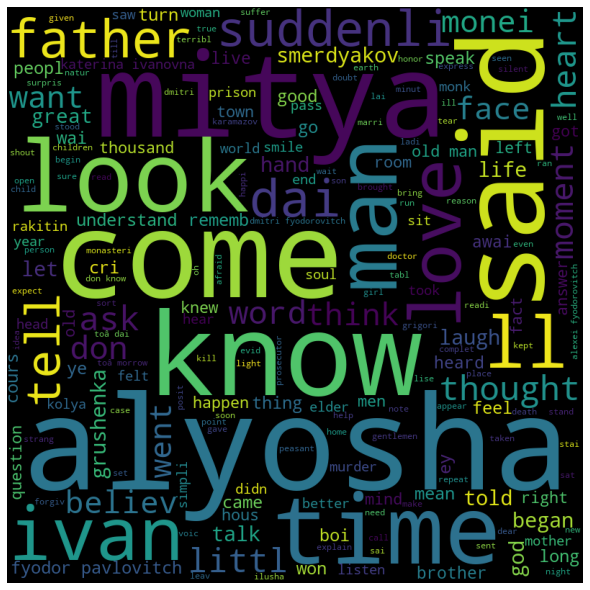

In [31]:
#word frequency for author Fyodor Dostoyevsky
texts = ''
for index, item in df1.iterrows():
    texts = texts + ' ' + clean_text(item['Content'])
    
plot_word_cloud(texts)

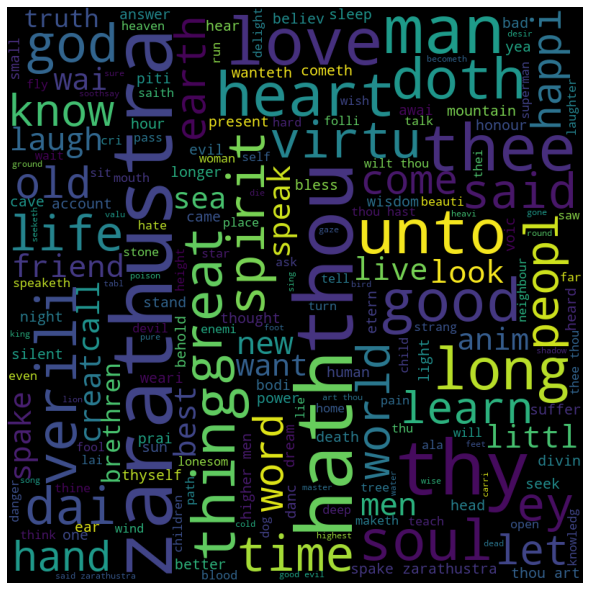

In [32]:
#word frequency for author 'By Friedrich Nietzsche'
texts = ''
for index, item in df2.iterrows():
    texts = texts + ' ' + clean_text(item['Content'])
    
plot_word_cloud(texts)

Clustering

In [33]:
def Clustering_model(X,df,n ,kmeans=True, HClustering= False, GMM =False):
  import matplotlib.pyplot as plt
  from itertools import cycle
  from sklearn.metrics import cohen_kappa_score
  from sklearn import metrics
  import numpy as np
  len_label = len(df)
  if kmeans == True:
    #k-means clustering
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    #print(cluster_centers)
    ##totall number of label
    labels_unique = np.unique(labels)
    ##numbers of label
    n_clusters_ = len(labels_unique)
    y_pred = kmeans.predict(X)
    print(y_pred)
    #calculate the labels
    y_true = np.array(y_pred)
    y_true[:len_label] = np.argmax(np.bincount(y_true[:len_label]))
    y_true[len_label:] = np.argmax(np.bincount(y_true[len_label:]))
    print(y_true)
    #Kappa Score
    Kappa = cohen_kappa_score(y_true, y_pred)
    print('Kmeans Kappa value: %0.4f' % Kappa)
    #silhouette score
    silihouette =metrics.silhouette_score(X, y_pred, metric='euclidean')
    print('Kmeans Silhoutte value: %0.4f' % silihouette)


  if HClustering == True:
    #Hierarchical Clustering
    from sklearn.cluster import AgglomerativeClustering
    ##setting Hierarchical Clustering
    linkages = ['ward', 'average', 'complete']
    n_clusters_ = n
    ac = AgglomerativeClustering(linkage=linkages[2],n_clusters = n_clusters_,affinity = 'euclidean')
    ##Train model
    y_pred = ac.fit_predict(X)
    print(y_pred)
    #calculate the labels
    y_true = np.array(y_pred)
    y_true[:len_label] = np.argmax(np.bincount(y_true[:len_label]))
    y_true[len_label:] = np.argmax(np.bincount(y_true[len_label:]))
    print(y_true)
    #Kappa Score
    Kappa = cohen_kappa_score(y_true, y_pred)
    print('Hclustering Kappa value: %0.4f' % Kappa)
    ##set labels
    lables = ac.labels_
    #silhouette score
    silhouette =metrics.silhouette_score(X, y_pred, metric='euclidean')
    print('Hclustering Silhouette value: %0.4f' % silhouette)

  if GMM == True:
    #GaussianMixtureModel
    ##设置gmm函数
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=n, covariance_type='spherical').fit(X)
    ##训练数据
    y_pred = gmm.predict(X)
    print(y_pred)
    #calculate labels
    y_true = np.array(y_pred)
    y_true[:len_label] = np.argmax(np.bincount(y_true[:len_label]))
    y_true[len_label:] = np.argmax(np.bincount(y_true[len_label:]))
    print(y_true)
    #Kappa Score
    Kappa = cohen_kappa_score(y_true, y_pred)
    print('GMM Kappa value: %0.4f' % Kappa)
    #silhouette score
    silhouette = metrics.silhouette_score(X, y_pred, metric='euclidean')
    print('GMM silhouette value: %0.4f' % silhouette)

In [34]:
len_label = len(Split_content(df1))

In [35]:
#doc2vec clustering result
X = np.asmatrix(np.array([transform_model.infer_vector(row.split()) for index, row in enumerate(df_h['Content'])]))
clustering_result = Clustering_model(X,Split_content(df1),2,1,0,0) 
print(clustering_result)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
Kmeans Kappa value: 0.9519
Kmeans Silhoutte value: 0.1509
None


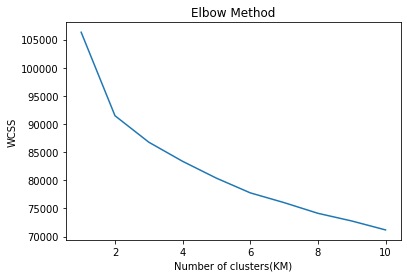

In [36]:
import matplotlib.pyplot as plt

#only for K-means
from sklearn.cluster import KMeans
wcss1 = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X)
  kmeans.predict(X)
  wcss1.append(kmeans.inertia_)
  linkages = ['ward', 'average', 'complete']
plt.plot(range(1, 11), wcss1)
plt.title('Elbow Method')
plt.xlabel('Number of clusters(KM)')
plt.ylabel('WCSS')
plt.show()

In [37]:
#TFIDF clustering result
X = tfidf_model.transform(df_h['Content']).toarray()
clustering_result = Clustering_model(X,Split_content(df1),2,0,0,1)
print(clustering_result)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
GMM Kappa value: 0.9468
GMM silhouette value: 0.0145
None


LSI and LDA model

In [38]:
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.ldamodel import LdaModel

In [39]:
dic_text = []
for i in range(len(df)):
  text = df.iloc[i]['Content']
  text_words = clean_text(text).split(' ')
  dic_text.append(text_words)

print(dic_text)

[['alexei', 'fyodorovitch', 'karamazov', 'son', 'fyodor', 'pavlovitch', 'karamazov', 'land', 'owner', 'known', 'district', 'dai', 'rememb', 'ow', 'gloomi', 'tragic', 'death', 'happen', 'thirteen', 'year', 'ago', 'shall', 'proper', 'place', 'present', '“landowner”—for', 'hardli', 'spent', 'dai', 'life', 'estate—wa', 'strang', 'type', 'pretti', 'frequent', 'met', 'type', 'abject', 'viciou', 'time', 'senseless', 'senseless', 'person', 'capabl', 'look', 'worldli', 'affair', 'appar', 'fyodor', 'pavlovitch', 'instanc', 'began', 'estat', 'smallest', 'ran', 'dine', 'men’', 'tabl', 'fasten', 'toadi', 'death', 'appear', 'thousand', 'roubl', 'hard', 'cash', 'time', 'life', 'senseless', 'fantast', 'fellow', 'district', 'repeat', 'stupidity—th', 'major', 'fantast', 'fellow', 'shrewd', 'intellig', 'enough—but', 'senseless', 'peculiar', 'nation', 'form', 'marri', 'twice', 'son', 'eldest', 'dmitri', 'wife', 'ivan', 'alexei', 'second', 'fyodor', 'pavlovitch’', 'wife', 'adelaã¯da', 'ivanovna', 'belong',

In [40]:
dictionary = corpora.Dictionary(dic_text)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dic_text]

In [51]:
from gensim.models.coherencemodel import CoherenceModel

start,stop,step = 2,10,1
def generate_plot(start,stop,step,LSI = True, LDA = False):
  coherence_values = []
  model_list = []
  for num_of_topics in range(start, stop, step):
    if LSI == True:
      # generate LSA model
      model = LsiModel(doc_term_matrix, num_topics=num_of_topics, id2word = dictionary)  # train model
    if LDA == True:
      model = LdaModel(doc_term_matrix, num_topics=number_of_topics)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=dic_text, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
      # Show graph
  x = range(start, stop, step)
  plt.plot(x, coherence_values)
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()

In [ ]:
generate_plot(2,9,1,0,1)

In [60]:
def topics(number_of_topics,words,LSI = True, LDA = False):
  if LSI == True:
    model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
  if LDA == True:
    model = LdaModel(doc_term_matrix, num_topics=number_of_topics)
  print(model.print_topics(num_topics=number_of_topics, num_words=words))

In [ ]:
topics(2,10,0,1)